Colunas do dataset:
Index(['freq_khz [kHz]', 'gap_size [mm]', 'winding_x_offset [m]', 'Freq [kHz]',
       'SolidLoss [W]'],
      dtype='object')
Train size: (900, 4), test size: (900, 4)

=== Training model: Linear Regression ===

=== Training model: Polynomial (2nd order) ===

=== Training model: SVR (RBF) ===

=== Training model: KNN Regressor ===

=== Training model: Random Forest ===

=== Training model: Gradient Boosting (tuned) ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best hyperparameters for Gradient Boosting (tuned):
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.8}

Results (sorted by R²):
                       Model      RMSE        R2
5  Gradient Boosting (tuned)  0.068105  0.999909
4              Random Forest  0.252462  0.998748
3              KNN Regressor  3.842310  0.710083
2                  SVR (RBF)  4.285179  0.639399
1     Polynomial (2nd order)  4.589831  0.586303
0          Linear Regression  5.945974  0.3057

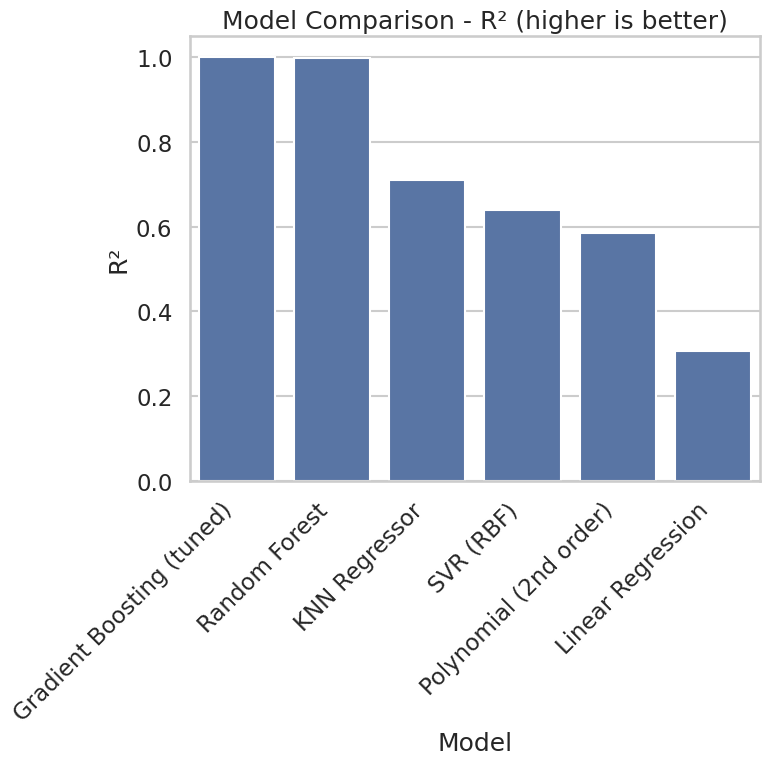

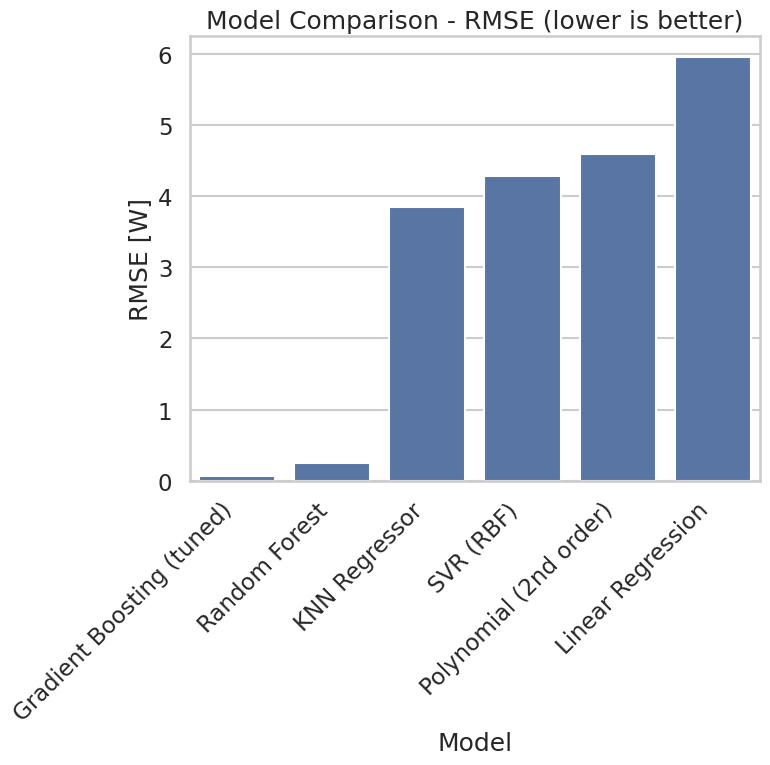

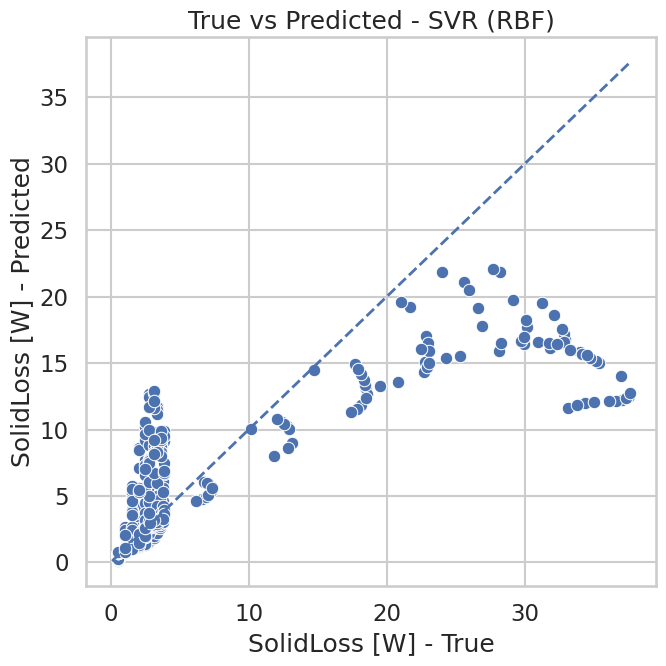

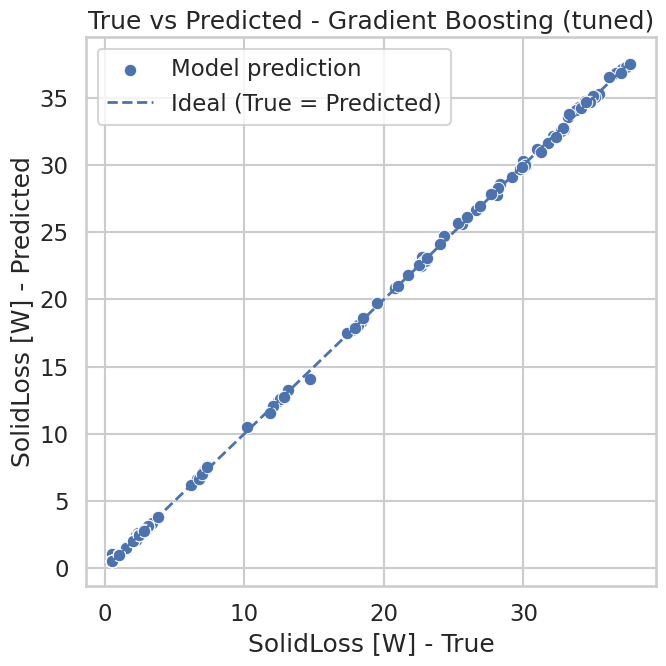

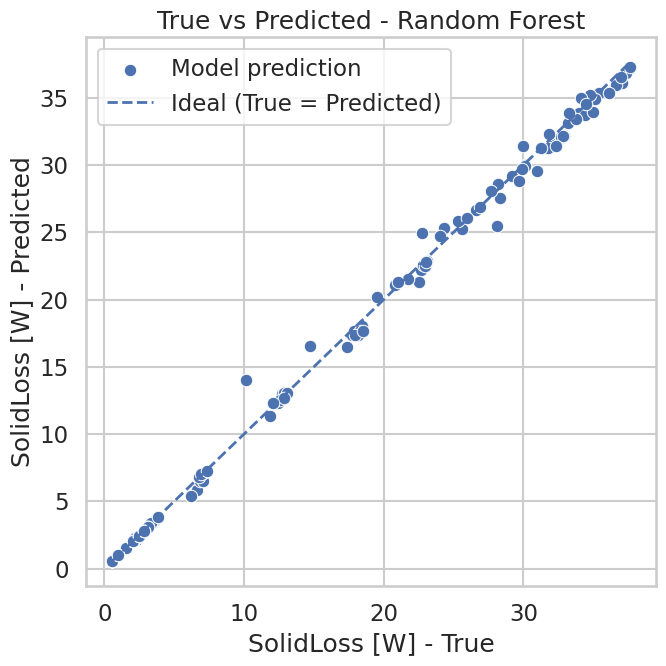

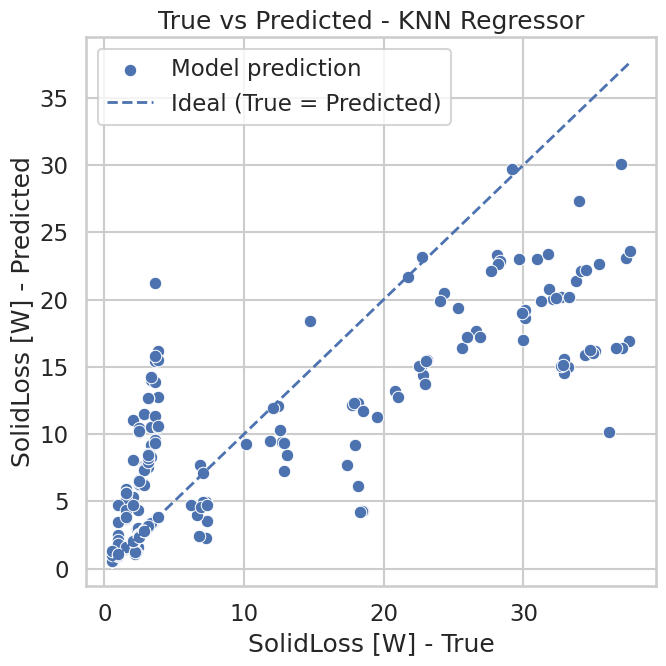

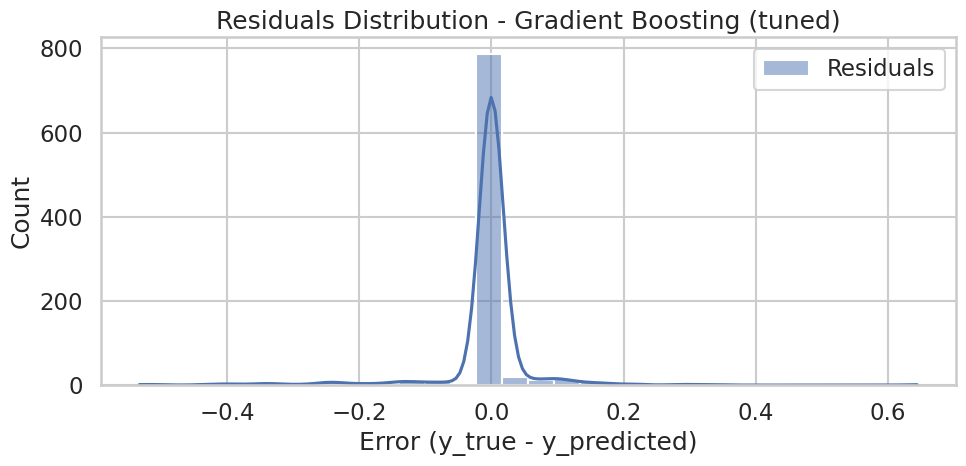

In [ ]:
# %% ==================== IMPORTS BÁSICOS ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Gráficos
sns.set(style="whitegrid", context="talk")

# %% ==================== CARREGAR DADOS ====================
csv_path = "/content/Parametric_Sweep_Loss_Table.csv"  # pasta dos dados
df = pd.read_csv(csv_path)

print("Colunas do dataset:")
print(df.columns)

# %% ==================== DEFINIR FEATURES E ALVO ====================
# Target: solid losses column
target_col = "SolidLoss [W]"

# Features: all other columns
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]      # features (model inputs)
y = df[target_col]        # target (output: SolidLoss [W])

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42  # 50% train / 50% test
)

print(f"Train size: {X_train.shape}, test size: {X_test.shape}")

# %% ==================== GRID SEARCH FOR GRADIENT BOOSTING ====================
# Base model
gb_base = GradientBoostingRegressor(random_state=42)

# Hyperparameter grid (for GridSearchCV)
gb_param_grid = {
    "learning_rate": [0.05, 0.1],
    "n_estimators": [300, 600],
    "max_depth": [2, 3],
    "subsample": [0.8, 1.0],
}

gb_grid = GridSearchCV(
    estimator=gb_base,
    param_grid=gb_param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

# %% ==================== DEFINE MODELS ====================
models = {
    "Linear Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("reg", LinearRegression())
    ]),

    "Polynomial (2nd order)": make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=2, include_bias=False),
        LinearRegression()
    ),

    "SVR (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("reg", SVR(kernel="rbf", C=10, epsilon=0.1))
    ]),

    "KNN Regressor": Pipeline([
        ("scaler", StandardScaler()),
        ("reg", KNeighborsRegressor(n_neighbors=5))
    ]),

    "Random Forest": RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ),

    # Gradient Boosting with hyperparameters tuned via GridSearchCV
    "Gradient Boosting (tuned)": gb_grid,
}

# %% ==================== TRAIN AND EVALUATE ====================
results = []

for name, model in models.items():
    print(f"\n=== Training model: {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # root MSE
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "R2": r2
    })

    # If GridSearchCV, show best hyperparameters
    if hasattr(model, "best_params_"):
        print(f"Best hyperparameters for {name}:")
        print(model.best_params_)

# DataFrame with results
results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
print("\nResults (sorted by R²):")
print(results_df)

# %% ==================== COMPARISON PLOTS ====================
# --- R² bar plot ---
plt.figure(figsize=(8, 8))  # mais vertical (padrão artigo)

sns.barplot(
    data=results_df,
    x="Model", y="R2"
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Model")
plt.ylabel("R²")
plt.title("Model Comparison - R² (higher is better)")

plt.tight_layout()
plt.savefig("model_comparison_R2.pdf")
plt.show()


# --- RMSE bar plot ---
plt.figure(figsize=(8, 8))  # mais vertical (padrão artigo)

sns.barplot(
    data=results_df,
    x="Model", y="RMSE"
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Model")
plt.ylabel("RMSE [W]")
plt.title("Model Comparison - RMSE (lower is better)")

plt.tight_layout()
plt.savefig("model_comparison_RMSE.pdf")
plt.show()

# %% ==================== TRUE vs PREDICTED - SVR (RBF) ====================
svr_model = models["SVR (RBF)"]
y_pred_svr = svr_model.predict(X_test)

plt.figure(figsize=(7, 7))

# Scatter: True vs Predicted
sns.scatterplot(x=y_test, y=y_pred_svr)

# Reference line y = x
min_val = min(y_test.min(), y_pred_svr.min())
max_val = max(y_test.max(), y_pred_svr.max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "--",
    linewidth=2
)

plt.xlabel("SolidLoss [W] - True")
plt.ylabel("SolidLoss [W] - Predicted")
plt.title("True vs Predicted - SVR (RBF)")

plt.tight_layout()
plt.savefig("true_vs_predicted_svr_rbf.pdf")
plt.show()


# %% ==================== TRUE vs PREDICTED (TOP 3 MODELS) ====================
# Get top 3 models by R²
top3 = results_df.head(3)["Model"].tolist()

for name in top3:
    model = models[name]
    # Already trained; just predict again
    y_pred = model.predict(X_test)

    plt.figure(figsize=(7, 7))
    # Scatter: True vs Predicted
    sns.scatterplot(x=y_test, y=y_pred, label="Model prediction")

    # Reference line y = x
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot(
        [min_val, max_val],
        [min_val, max_val],
        "--",
        linewidth=2,
        label="Ideal (True = Predicted)"
    )

    plt.xlabel("SolidLoss [W] - True")
    plt.ylabel("SolidLoss [W] - Predicted")
    plt.title(f"True vs Predicted - {name}")
    plt.legend()

    plt.tight_layout()

    # Save each plot as PDF (sanitize model name for filename)
    safe_name = (
        name.lower()
        .replace(" ", "_")
        .replace("(", "")
        .replace(")", "")
        .replace("/", "_")
    )
    plt.savefig(f"true_vs_predicted_{safe_name}.pdf")
    plt.show()

# %% ==================== RESIDUALS OF BEST MODEL ====================
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True, label="Residuals")
plt.title(f"Residuals Distribution - {best_model_name}")
plt.xlabel("Error (y_true - y_predicted)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()

safe_best = (
    best_model_name.lower()
    .replace(" ", "_")
    .replace("(", "")
    .replace(")", "")
    .replace("/", "_")
)
plt.savefig(f"residuals_{safe_best}.pdf")
plt.show()
